In [1]:
import os
import torch
from model.faster_rcnn_vgg16 import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
from data.util import read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
import numpy as np
%matplotlib inline

/datasets/home/home-00/06/206/j1burke/ECE285/ECE285_Sauvage_Object_Detection/model/utils/nms/non_maximum_suppression.py:12: UserWarning: 
    the python code for non_maximum_suppression is about 2x slow
    It is strongly recommended to build cython code: 
    `cd model/utils/nms/; python3 build.py build_ext --inplace
  `cd model/utils/nms/; python3 build.py build_ext --inplace''')


## Load Datasets and Model

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/opt/conda/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chun

Exception in user code:
------------------------------------------------------------
0.0


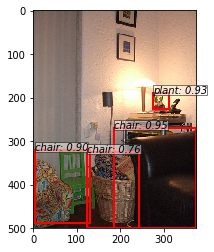

In [ ]:
from PascalVOCDataloader import PascalVOCDataloader, create_split_loaders
data_dir = '/datasets/ee285f-public/PascalVOC2012/'
model_dir = 'model/'
test_file = 'RCNN_Pretrained'

# Load Dataset
dataset = PascalVOCDataloader(data_dir, pretrained=True)
train_loader, val_loader, test_loader = create_split_loaders(dataset,batch_size=1)

# Load Model
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn).cuda()
trainer.load(model_dir+'fasterrcnn_12211511_0.701052458187_torchvision_pretrain')
img, q, e = next(iter(val_loader))
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=False, score_thresh=0.7)
print(np.min(at.tonumpy(img[0])))
vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

## Evaluate and Save Testing Outputs

In [ ]:
import pandas as pd
n_classes = 20
class_labels = [i for i in range(n_classes)]

### Load Results into Dataframe ###
PRED_COL = ['img_num', 'pred_bboxes', 'pred_labels', 'pred_scores']
Predicted_Data = pd.DataFrame(columns=PRED_COL)
TRUE_COL = ['img_num', 'true_bboxes', 'true_labels']
True_Data = pd.DataFrame(columns=TRUE_COL)
n_pred_bboxes = 0
n_pred_thresh = 1000
class_check = np.zeros((n_classes))
for img_num, (img, true_bboxes, true_labels) in enumerate(test_loader, 0):
    true_bboxes, true_labels, = true_bboxes.numpy()[0], true_labels.numpy()[0]
    pred_bboxes, pred_labels, pred_scores = trainer.faster_rcnn.predict(img,visualize=False, score_thresh=0.45)
    pred_bboxes, pred_labels, pred_scores = np.asarray(pred_bboxes)[0], np.asarray(pred_labels)[0], np.asarray(pred_scores)[0]
    n_pred = pred_bboxes.shape[0]
    for i in range(n_pred):
        tmp_df = pd.DataFrame([[img_num, pred_bboxes[i], pred_labels[i], pred_scores[i]]], columns=PRED_COL)
        Predicted_Data = Predicted_Data.append(tmp_df, ignore_index=True)
    n_true = true_bboxes.shape[0]
    for i in range(n_true):
        tmp_df = pd.DataFrame([[img_num, true_bboxes[i], true_labels[i]]], columns=TRUE_COL)
        True_Data = True_Data.append(tmp_df, ignore_index=True)
        class_check[true_labels[i]] = 1
    n_pred_bboxes += pred_bboxes.shape[0]
    if (n_pred_bboxes > n_pred_thresh and (np.sum(class_check) == 20)):
        print('Test conditions reached with %d test images and %d predicted boxes' % (img_num, n_pred_bboxes))
        break

Predicted_Data.to_pickle(test_file+'_Predicted_Data.pkl')
True_Data.to_pickle(test_file+'_True_Data.pkl')
print(Predicted_Data.shape[0])


## Calculate Precision and Recall

In [ ]:
from IoU import bb_intersection_over_union
Predicted_Data = pd.read_pickle(test_file+'_Predicted_Data.pkl')
True_Data = pd.read_pickle(test_file+'_True_Data.pkl')
#True_Data.to_pickle('RCNN_True_Data.pkl')
Predicted_Data.sort_values(['pred_scores'], axis=0, ascending=False, inplace=True)
Predicted_Data.reset_index(inplace=True)
#print(Predicted_Data[:4])
#print(True_Data['true_labels'].value_counts())
def calc_precision_recall(Predicted_Data, True_Data, class_labels):
    Predicted_Data = Predicted_Data.sort_values(['pred_scores'], axis=0, ascending=False, inplace=False)
    Predicted_Data = Predicted_Data.reset_index(inplace=False)
    n_classes = len(class_labels)
    mAP_thresh = 0.5
    
    n_pred = Predicted_Data.shape[0]
    Precision = np.zeros((n_pred))
    Recall = np.zeros((n_pred))
    TP_FN = True_Data['true_labels'].value_counts()
    for p in range(1,n_pred+1):
        pred_data = Predicted_Data[:p]
        class_precision = []
        class_recall = []
        for c in range(n_classes):
            if  not(TP_FN.keys().contains(c)):
                continue
            cl = class_labels[c]
            pred_data_cl = pred_data.loc[pred_data['pred_labels'] == cl]
            n_bboxes = pred_data_cl.shape[0]
            TP = 0
            FP = 0
            # Check if positives are True or False
            for _,pred_row in pred_data_cl.iterrows():
                pred_bbox = pred_row['pred_bboxes']
                img_num = pred_row['img_num']
                true_data = True_Data.loc[True_Data['img_num'] == img_num]
                true_data = true_data.loc[true_data['true_labels'] == cl]
                n_true_bboxes = true_data.shape[0]
                # Calculate iou between ground truth and predictions
                max_iou = 0
                for _,true_row in true_data.iterrows():
                    true_bbox = true_row['true_bboxes']
                    iou = bb_intersection_over_union(pred_bbox, true_bbox)
                    if (iou > max_iou):
                        max_iou = iou
                if (max_iou >= mAP_thresh):
                    TP += 1
                elif (max_iou < mAP_thresh):
                    FP += 1
            if (n_bboxes > 0):
                class_precision.append(TP/(TP+FP))
                class_recall.append(TP/TP_FN[cl])
        if(len(class_precision) > 0):
            Precision[p-1] = sum(class_precision)/len(class_precision)
            Recall[p-1] = sum(class_recall)/len(class_recall)

    return Precision, Recall

Precision, Recall = calc_precision_recall(Predicted_Data, True_Data, class_labels)
#TP_FN = True_Data['true_labels'].value_counts()
#print(type(TP_FN), TP_FN.keys().contains(9))

## Plot Total PR Curve and Calculate mAP

In [ ]:

from matplotlib import pyplot as plt
plt.plot(Recall, Precision, '.')
#print(Precision, Recall)
def calculate_mAP(Recall, Precision):
    N = Precision.shape[0]
    # Smooth precision curve
    for i in range(N-1):
        ind_right = (Recall >= Recall[i])
        Precision[i] = max(Precision[i], np.max(Precision[ind_right]))
    # Interpolate PR values
    recall_steps = np.linspace(0,1,11)
    Interp_Precision = np.zeros(11)
    for i in range(11):
        r = recall_steps[i]
        ind_closest = np.argmin(np.absolute(r - Recall))
        if (np.absolute(Recall[ind_closest] - r) <= 0.1):
            Interp_Precision[i] = Precision[ind_closest]
            Recall[ind_closest] = 0
    mAP = np.sum(Interp_Precision)/11
    return mAP

mAP = calculate_mAP(Recall, Precision)
print(mAP)

## Plot Class Specific PR Curves

In [ ]:
from matplotlib import pyplot as plt

Predicted_Data = pd.read_pickle(test_file+'_Predicted_Data.pkl')
True_Data = pd.read_pickle(test_file+'_True_Data.pkl')


classes = {0:'Aeroplane', 1:'Bicycle',2:'Bird',3:'Boat',4:'Bottle',5:'Bus',
                        6:'Car', 7:'Cat',8:'Chair',9:'Cow',10:'Diningtable',11:'Dog',
                        12:'Horse', 13:'Motorbike',14:'Person',15:'Potted Plant',
                        16:'Sheep', 17:'Sofa',18:'Train',19:'Tv Monitor'}
# Plot Precision Recall for each class
fig = plt.figure()
fig.set_figheight(16)
fig.set_figwidth(20)
for c in class_labels:
    P,R = calc_precision_recall(Predicted_Data, True_Data, [c])
    plt.subplot(5, 4, c+1)
    plt.plot(R, P, '.')
    plt.xlabel('Recall',fontsize=16)
    plt.ylabel('Precision',fontsize=16)
    plt.title(' Class = '+ classes[c],fontsize=20)
    plt.rc('xtick',labelsize=14)
    plt.rc('ytick',labelsize=14)
    plt.tight_layout()
plt.show()
fig.savefig('plot/'+test_file+'_Class_PR.png')